# Introduction </br>
The following script shows how to the workflow of a ML-Algorithm (Light GBM Regression) on a dataset (DDA purchase and newsletter data)

# Installation</br>
Install [python 3.11](https://www.python.org/downloads/release/python-3110/) </br>
Install matplotlib: pip3 install matplotlib</br>
Install seaborn   : pip3 install seaborn </br>
Install lightgbm  : pip3 install lightgbm </br>

# Imports

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer as Imputer
from sklearn.model_selection import cross_val_score
import os
import sys
import optunity.metrics
import joblib
import json

Get the root directory dependent on executed by real python script or jupyter notebook

In [93]:
script_directory = os.path.dirname(os.path.dirname(os.path.realpath(sys.argv[0])))
print(script_directory)
if os.path.basename(script_directory).startswith("Python"):
    script_directory = "../"
    %matplotlib inline
else:
    script_directory = os.path.dirname(os.path.dirname(os.path.realpath(sys.argv[0])))

C:\Users\karls\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311


Specify the version number of the model

In [94]:
dir_content= os.listdir(script_directory + "/data/results")
version = len(dir_content) # starts from 1 since a ".gitignore" is in the directory
version

3

# Data Analysis

In [95]:
df_train   = pd.read_csv(script_directory + "/data/learning/ml-learning-data.csv",   sep=';', na_values=['', '-'], parse_dates=['LastNewsletter', 'date'], dayfirst=True)
df_predict = pd.read_csv(script_directory + "/data/predicting/ml-prediction-data.csv", sep=';', na_values=['', '-'], parse_dates=['LastNewsletter', 'date'], dayfirst=True)
df_train['DaysSinceLastNewsletter'] = df_train['DaysSinceLastNewsletter'].str.replace(',', '.').astype(float)
df_predict['DaysSinceLastNewsletter'] = df_predict['DaysSinceLastNewsletter'].str.replace(',', '.').astype(float)

df_train['id'] = [i for i in range(len(df_train.index))]
df_predict['id'] = [i for i in range(len(df_predict.index))]

In [96]:
df_train.sample(3)

,Customerid,date,Orderid,Produktkey_Orders,DaysSinceLastNewsletter,DaysUntilNextPurchase,FirstProductOrder,LastNewsletter,Units,Preis,UnitRelativeDays,id
12992,61862de89f8155001c7d6b20,2023-06-26,649987a91f512b55918f595d,6197e4e11ea6b1003bd1c0cb,NaN,105,0,NaT,3,12,35,12992
1296,61862c7f9f8155001c7c0edd,2022-09-01,63104debf3b6f40024b27fe9,6197e2751ea6b1003bd1bbd3,14.257123,152,0,2022-08-18,1,9,152,1296
6554,61862de89f8155001c7d6b20,2023-09-04,64f5d1dc857dfe05af0d8376,6197e6961ea6b1003bd1c33f,10.091204,1,0,2023-08-25,1,16,1,6554


DaysUntilNextPurchase is nothing we know at the time we want to predict so we drop it.<br/>Also Last Newsletter is directly connected to DaysSinceLastNewsletter and date. Therefore it has to be dropped as well.

In [97]:
df_train.drop(['DaysUntilNextPurchase', 'LastNewsletter'], axis=1, inplace=True)

In [98]:
"Training dataset: {}".format(df_train.shape)

'Training dataset: (13292, 10)'

13.292 Lines and 10 Columns

In [99]:
df_predict.sample(3)


,Customerid,date,Orderid,Produktkey_Orders,DaysSinceLastNewsletter,DaysUntilNextPurchase,FirstProductOrder,LastNewsletter,LastProductOrder,Preis,UnitRelativeDays,Units,id
6421,64ae5d813ce7f877629d9a0d,2023-07-12,64ae5d813ce7f877629d9a0e,6185983979aba3003f6d1514,6.487710,37,1,2023-07-05,1,32,37,1,6421
4377,649deaf78cd5f0d97e274db1,2023-06-29,649de2c48cd5f0d97e274a6d,6185b8ffbfc409003fcb3930,NaN,162,1,NaT,1,33,162,1,4377
3842,6346d5a0da21cd002f0da7f6,2022-11-10,636cf01cb2ee8e002f0cf2f6,6185a9cabfc409003fcb2c49,35.518535,34,1,2022-10-06,1,68,34,1,3842


UnitRelativeDays is our prediction column and DaysUntilNextPurchase is nothing we know at the time we want to predict so we drop it.<br/>Also Last Newsletter is directly connected to DaysSinceLastNewsletter and date. Therefore it has to be dropped as well.

In [100]:
df_predict.drop(['UnitRelativeDays', 'DaysUntilNextPurchase', 'LastNewsletter'], axis=1, inplace=True)

In [101]:
"Prediction dataset: {}".format(df_predict.shape)

'Prediction dataset: (8749, 10)'

Dataset has 8749 Lines and 10 Columns

In [102]:
df_train.describe()

,date,DaysSinceLastNewsletter,FirstProductOrder,Units,Preis,UnitRelativeDays,id
count,13292,7882.000000,13292.000000,13292.000000,13292.000000,13292.000000,13292.000000
mean,2023-02-07 03:06:00.758350848,13.219214,0.171908,2.142116,75.155206,53.486082,6645.500000
min,2022-07-01 00:00:00,0.000588,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2022-10-12 00:00:00,4.977636,0.000000,1.000000,18.000000,7.000000,3322.750000
50%,2023-01-19 00:00:00,11.120121,0.000000,1.000000,34.000000,28.000000,6645.500000
75%,2023-06-01 00:00:00,19.312839,0.000000,2.000000,74.000000,77.000000,9968.250000
max,2023-12-15 00:00:00,47.956406,1.000000,288.000000,23409.000000,299.000000,13291.000000
std,NaN,10.960125,0.377315,5.060588,369.612333,62.877363,3837.214224


df_predict.describe()

LastProductOrder is always 1 and not included in the training dataset so we can drop it

In [103]:
df_predict.drop(['LastProductOrder'], axis=1, inplace=True)

Date is in date format but ML needs floats or bools so we convert it into a timestamp

In [104]:
df_train['date'] = pd.to_datetime(df_train['date']).astype('int64') // 10**9
df_predict['date'] = pd.to_datetime(df_predict['date']).astype('int64') // 10**9

In [105]:
print('''After edditing,
Training dataset has {} lines and {} columns and
Prediction dataset has {} lines and {} columns
'''.format(df_train.shape[0], df_train.shape[1], df_predict.shape[0], df_predict.shape[1]))

After edditing,
Training dataset has 13292 lines and 10 columns and
Prediction dataset has 8749 lines and 9 columns



<Axes: xlabel='UnitRelativeDays', ylabel='Count'>

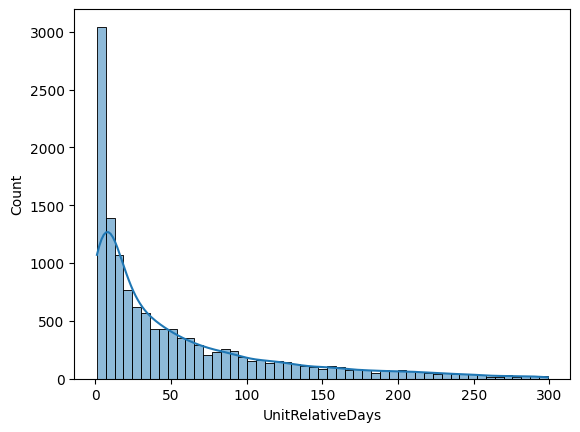

In [106]:
sns.histplot(df_train['UnitRelativeDays'], kde=True)

Looks like a negative exponential function -> looks normal

# Data Engineering

Bring the data into the correct format. Herefor also all NULL values have to be replaced.

### def fill_missing:
Fills the NULL values of the given columns (cols) with the given value (val)

In [107]:
def fill_missing(df, cols, val):
    for col in cols:
        df[col] = df[col].fillna(val)

### def fill_missing_with_mode:
Fills the NULL values of the given columns (cols) with the most used value in the column

In [108]:
def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

### def addlogs
Calculate a logagithm function on the given dataframe (res). The logarithm function is on the base of 10 and adds a Constant (1.01) to make sure the input is not <=0, The result is stored in a new column: *NAME*_log

In [109]:
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

## Feature Engeneering
We could also add some calculated features that are no direct columns in the inputdata, but we did this here already before. DaysSinceLastNewsletter, DaysUntilNextPurchase, FirstProductOrder, LastNewsletter, UnitRelativeDays are all feature engeneered columns

# Feature handling
## Logs

Calculate the log for all simple integer features

In [110]:
loglist = ['Units', 'Preis'] # + ['UnitRelativeDays']
df_train = addlogs(df_train, loglist)
#df_predict = addlogs(df_predict, loglist)

Calculate the natural log for real valued numbers

In [111]:
#df_train['Units'] = np.log1p(df_train['Units'])
#df_train['Preis'] = np.log1p(df_train['Preis'])

## Fill missing values 

In [112]:
fill_missing(df_train, ['Customerid', 'Orderid', 'Produktkey_Orders'], "Null")
fill_missing(df_train, ['FirstProductOrder', 'Units'], 1)
#fill_missing(df_train, ['DaysSinceLastNewsletter'], 17)

fill_missing_with_mode(df_train, ['Preis', 'UnitRelativeDays', 'DaysSinceLastNewsletter', 'date'])

## Type conversions
Check that every type is correct for handling the data.<br/>
If there would be any categorical columns that consist of numeric values we should transform the type in the dataframe to string. We do not have this in our usecase. <br/>Example:

In [113]:
#df_train['WineQuality'] = df_train['WineQuality'].apply(str)
#df_train['YearCreated'] = df_train['YearCreated'].astype(str)

## Remove Outliers
Identify Outliers by useing interquartile range (IQR). IQR represents the interquartile range calculated by Q3(75th percentile of the dataset) minus Q1(25th percentile of the dataset) (Q3–Q1).

### Identify Outliers

In [114]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [115]:
outliers = find_outliers_IQR(df_train[['UnitRelativeDays', 'DaysSinceLastNewsletter', 'Units', 'Preis']])
print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers: 13292
max outlier value: UnitRelativeDays             299.000000
DaysSinceLastNewsletter       47.956406
Units                        288.000000
Preis                      23409.000000
dtype: float64
min outlier value: UnitRelativeDays           183.000000
DaysSinceLastNewsletter     36.455087
Units                        4.000000
Preis                      159.000000
dtype: float64


,UnitRelativeDays,DaysSinceLastNewsletter,Units,Preis
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,164.0
4,NaN,NaN,NaN,NaN
...,...,...,...,...
13287,NaN,NaN,NaN,NaN
13288,NaN,NaN,NaN,NaN
13289,NaN,NaN,5.0,NaN
13290,NaN,NaN,NaN,NaN


In [116]:
def set_min_max(df, col, range):
    min = df[col].mean() - range*df[col].std()
    max = df[col].mean() + range*df[col].std()
    df[col] = np.where(df[col] > max,
                max,
                   np.where(df[col] < min, min,
                            df[col]
                           )

                )

set_min_max(df_train, 'UnitRelativeDays', 3)
set_min_max(df_train, 'DaysSinceLastNewsletter', 3)
set_min_max(df_train, 'Units', 2)
set_min_max(df_train, 'Preis', 1)
df_train.describe()

,date,DaysSinceLastNewsletter,FirstProductOrder,Units,Preis,UnitRelativeDays,id,Units_log,Preis_log
count,1.329200e+04,13292.000000,13292.000000,13292.000000,13292.000000,13292.000000,13292.000000,13292.000000,13292.000000
mean,1.675739e+09,15.674837,0.171908,1.941332,61.146027,52.992898,6645.500000,0.968059,3.648163
std,1.215460e+07,8.822362,0.377315,1.992051,74.512587,61.227864,3837.214224,0.463340,1.000424
min,1.656634e+09,0.000588,0.000000,1.000000,0.000000,1.000000,0.000000,0.698135,0.009950
25%,1.665533e+09,7.962250,0.000000,1.000000,18.000000,7.000000,3322.750000,0.698135,2.944965
50%,1.674086e+09,19.358180,0.000000,1.000000,34.000000,28.000000,6645.500000,0.698135,3.555634
75%,1.685578e+09,19.358180,0.000000,2.000000,74.000000,77.000000,9968.250000,1.101940,4.317621
max,1.702598e+09,42.605140,1.000000,12.263292,444.767540,242.118170,13291.000000,5.666461,10.060919


## Handle Categoricals

In [117]:
def fix_missing_cols(in_train, in_test):
    missing_cols = list(set(in_train.columns) - set(in_test.columns))
    
    # Create a DataFrame with missing columns and default value 0
    missing_cols_df = pd.DataFrame(0, index=in_test.index, columns=missing_cols)
    
    # Concatenate the missing columns DataFrame with in_test
    in_test = pd.concat([in_test, missing_cols_df], axis=1)
    
    # Ensure the order of columns in the test set is the same as in the train set
    in_test = in_test[in_train.columns]
    
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_predict = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object' and f != "id"
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_predict = pd.concat([df_predict, pd.get_dummies(df_predict[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_predict = fix_missing_cols(df_train, df_predict)
    return df_train, df_predict

In [118]:
#set(df_train.columns) - set(df_predict.columns)
df_train, df_predict = dummy_encode(df_train, df_predict)

['Customerid', 'Orderid', 'Produktkey_Orders']


In [119]:
print("Shape train: %s, test: %s" % (df_train.shape, df_predict.shape))

Shape train: (13292, 11689), test: (8749, 11689)


## Feature Engeneering

In [120]:
#df_train.corr(numeric_only=True)

In [121]:
def load_poly_features(df_train, df_predict, cols):
    """
    USeful function to generate poly terms
    :param df_train: The training data frame
    :param df_predict: The test data frame
    :return: df_poly_features, df_poly_features_test - The training polynomial features + the test
    """
    print('Loading polynomial features..')
    # Make a new dataframe for polynomial features
    poly_features = df_train[cols]
    poly_features_test = df_predict[cols]

    # imputer for handling missing values
    imputer = Imputer(strategy='median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)
    poly_features_test = imputer.transform(poly_features_test)

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=3)
    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    poly_features_test = poly_transformer.transform(poly_features_test)
    print('Polynomial Features shape: %s' % str(poly_features.shape))
    
    # Generate column names for the DataFrame
    column_names = [f"poly_{i}" for i in range(poly_features.shape[1])]
    
    df_poly_features = pd.DataFrame(poly_features, columns=column_names)
    df_poly_features_test = pd.DataFrame(poly_features_test, columns=column_names)
    df_poly_features['id'] = df_train['id']
    df_poly_features_test['id'] = df_predict['id']
    print('Loaded polynomial features')
    return df_poly_features, df_poly_features_test

In [122]:
correlated_cols = ['Units', 'Preis']
df_train_poly, df_predict_poly =  load_poly_features(df_train, df_predict, cols=correlated_cols)
print("Shape train: %s, predict: %s" % (df_train_poly.shape, df_predict_poly.shape))

Loading polynomial features..
Polynomial Features shape: (13292, 10)
Loaded polynomial features
Shape train: (13292, 11), predict: (8749, 11)


In [123]:
df_train = df_train.merge(right=df_train_poly.reset_index(), how='left', on='id')
df_predict = df_predict.merge(right=df_predict_poly.reset_index(), how='left', on='id')

In [124]:
print("Shape train: %s, predict: %s" % (df_train.shape, df_predict.shape))

Shape train: (13292, 11700), predict: (8749, 11700)


# Light GBM

In [125]:
y = df_train["UnitRelativeDays"]
y.sample(3)

1746     73.0
5690      3.0
9945    203.0
Name: UnitRelativeDays, dtype: float64

In [126]:
print("Shape train: %s, test: %s" % (df_train.shape, df_predict.shape))

Shape train: (13292, 11700), test: (8749, 11700)


In [127]:
df_train.sample(2)

,date,DaysSinceLastNewsletter,FirstProductOrder,Units,Preis,UnitRelativeDays,id,Units_log,Preis_log,Customerid_61862c7c9f8155001c7bf0b3,...,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9
2259,1664323200,21.437619,0,12.263292,159.0,4.0,2259,3.044999,5.075236,False,...,1.0,12.263292,159.0,150.388321,1949.863364,25281.0,1844.255831,23911.743007,310028.274869,4019679.0
8320,1657670400,19.358180,1,6.000000,76.0,10.0,8320,1.947338,4.343935,False,...,1.0,6.000000,76.0,36.000000,456.000000,5776.0,216.000000,2736.000000,34656.000000,438976.0


In [128]:
df_train.drop(["UnitRelativeDays"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
df_predict.drop(["UnitRelativeDays"], axis=1, inplace=True) 

In [129]:
X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)

Define the objective function to be minimized (in this case, the RMSE) by using optunity to optimize the hyperparameters

In [130]:
#@optunity.cross_validated(x=X_train, y=y_train, num_folds=5, num_iter=2) runs into errors so I use it in the function itself
def objective_function(num_leaves, learning_rate, feature_fraction):
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction
    }

    # Combine X_train and y_train to create a complete training set
    data = lgb.Dataset(df_train, label=y)

    # Perform cross-validation using LightGBM
    cv_scores = cross_val_score(lgb.LGBMRegressor(**params), X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean of the cross-validation scores
    mean_cv_score = np.mean(cv_scores)

    # Optunity minimizes the objective function, so return the negative mean CV score
    return -mean_cv_score

Define the search range for hyperparameters

In [131]:
search_space = {'num_leaves': [32, 256],
                'learning_rate': [0.001, 0.1],
                'feature_fraction': [0.5, 1.0]}

Run the optimization using [Opunity](https://optunity.readthedocs.io/en/latest/)

In [132]:
optimal_params, _, _ = optunity.minimize(objective_function, num_evals=50, **search_space)
'''
optimal_params = {
    'num_leaves': 60.411096247576594,
    'learning_rate': 0.07844816406249999,
    'feature_fraction': 0.7417382812499999
}
'''
optimal_params

[LightGBM] [Warning] feature_fraction is set=0.61083984375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61083984375
[LightGBM] [Warning] feature_fraction is set=0.61083984375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61083984375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 8506, number of used features: 140
[LightGBM] [Info] Start training from score 52.941989
[LightGBM] [Warning] feature_fraction is set=0.61083984375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61083984375
[LightGBM] [Warning] feature_fraction is set=0.61083984375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61083984375
[LightGBM] [Warning] feature_fraction is set=0.61083984375, colsample_bytree=1.0 

{'num_leaves': 66.73662865087309,
 'learning_rate': 0.06464230468750001,
 'feature_fraction': 0.6570898437499999}

Train the Model based on the hyperparameters we just found

In [133]:
optimal_params['num_leaves'] = int(optimal_params['num_leaves'])
final_train_data = lgb.Dataset(X_train, label=y_train)
final_test_data = lgb.Dataset(X_test, label=y_test, reference=final_train_data)
final_bst = lgb.train({'objective': 'regression',
                        'metric': 'mse',
                        'boosting_type': 'gbdt',**optimal_params}, final_train_data, 100000, valid_sets=[final_test_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3456
[LightGBM] [Info] Number of data points in the train set: 10633, number of used features: 177
[LightGBM] [Info] Start training from score 53.163630


Make the prediction on the set where we know the answer

In [134]:
y_pred = final_bst.predict(X_train, num_iteration=final_bst.best_iteration)

In [135]:
mse = mean_squared_error(y_train, y_pred)
rmse = round((mse) ** 0.5, 5)
print('The RMSE of prediction is:', rmse)
with open(script_directory + "/data/parameters/training_model-V{}.json".format(version), "w") as json_file:
    json.dump({'parameters': optimal_params, 'rmse': rmse}, json_file, indent=2)

The RMSE of prediction is: 7.76403


Make the actual Prediction on data where we don't know the solution (in this case we know for testing purposes)

In [136]:
prediction = final_bst.predict(df_predict, num_iteration=final_bst.best_iteration)

In [137]:
prediction

array([140.0487447 , 105.86633212,  24.98215318, ...,  81.7260037 ,
        72.54974624,  73.26637372])

Store the result in a file

In [138]:
df_predict["UnitRelativeDays"] = prediction

In [139]:
df_predict.to_csv(script_directory + "/data/results/results-V{}.csv".format(version), columns=["id", "UnitRelativeDays"], index=False, sep=';')

Store the trained model in a file

In [140]:
joblib.dump(final_bst, script_directory + '/trained_models/ML-V{}-DDA.pkl'.format(version))

['..//trained_models/ML-V3-DDA.pkl']